In [1]:
%pylab inline
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the dataset saved in the previous notebook
dcps = xr.open_dataset('/Users/thedon/Dropbox/Work/SailBuoy Internship/Data/2022_SOCHIC_Maudrise/DCPS_corrected.nc')

### Firstly, we need to check strength levels and determine a good cutoff value.

We start with -40dB, as this is the first flag in from the sensor itself

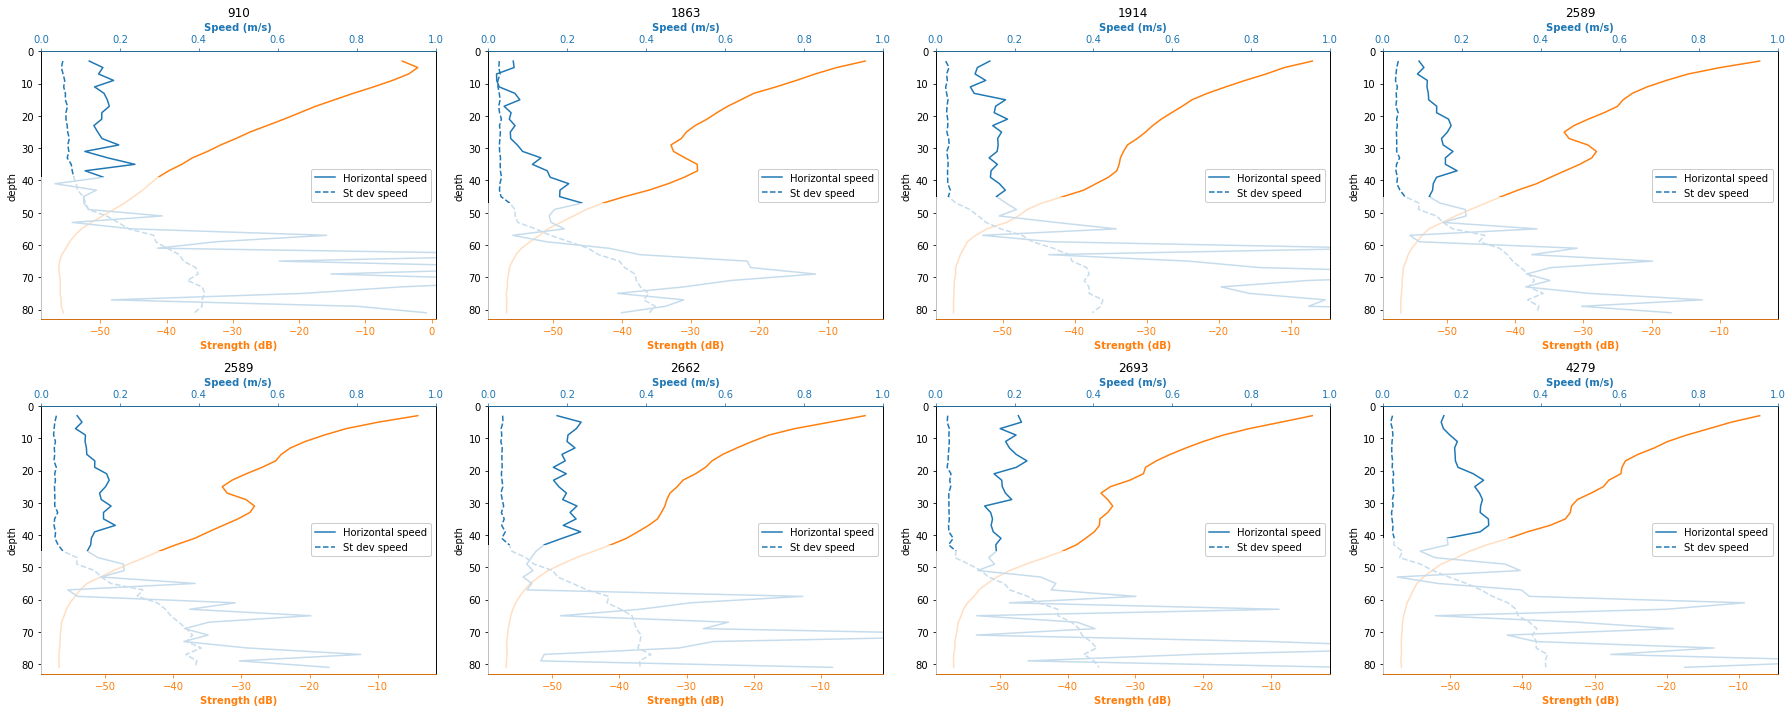

In [3]:
# Plot some random profiles of speed, std, and strength. Dim everything thats below -40dB strength
a = 2
b = 4
fig, ax = plt.subplots(a,b,figsize=(25,10))
I = np.sort(np.random.randint(len(dcps.time),size=a*b))
for j in range(a):
    for k in range(b):
        axt = ax[j][k]
        ax1 = axt.twiny()
        i = I[j*3 + k]
        dcps.isel(time=i)['horizontal_speed'].plot(y='depth',ylim=(83,0),alpha=1,c='C0',ax=ax1,label='Horizontal speed')
        (dcps.isel(time=i)['sp_sd_horizontal']/100/sqrt(149)).plot(y='depth',ylim=(83,0),alpha=1,c='C0',ls='--',ax=ax1,label='St dev speed')
        dcps.isel(time=i)['strength'].plot(y='depth',ylim=(83,0),alpha=1,c='C1',ax=axt)
        ax1.axhspan(dcps.isel(time=i).depth.where(dcps.isel(time=i)['strength'] > -40).max()+2,83,0,1,fc='w',alpha=0.75,zorder=4)
        ax1.set_xlabel('Speed (m/s)',c='C0',fontweight='bold')
        axt.set_xlabel('Strength (dB)',c='C1',fontweight='bold')
        ax1.set_title('')
        axt.set_title(str(i))
        ax1.set_ylabel('')
        ax1.legend(loc='center right',framealpha=1)
        ax1.set_xlim(0,1)
        
        axt.xaxis.label.set_color('C1')        #setting up X-axis label color to yellow
        ax1.xaxis.label.set_color('C0')          #setting up Y-axis label color to blue
        axt.tick_params(axis='x', colors='C1')    #setting up X-axis tick color to red
        ax1.tick_params(axis='x', colors='C0')  #setting up Y-axis tick color to black
        ax1.spines['bottom'].set_color('C1')        # setting up Y-axis tick color to red
        ax1.spines['top'].set_color('C0')         #setting up above X-axis tick color to red
        
plt.tight_layout()

This looks quite good, std seem to increase when strength drop below -40dB. Then we know that we have to cut off at -40dB. Let's check some other parameters that the sensor outputs.

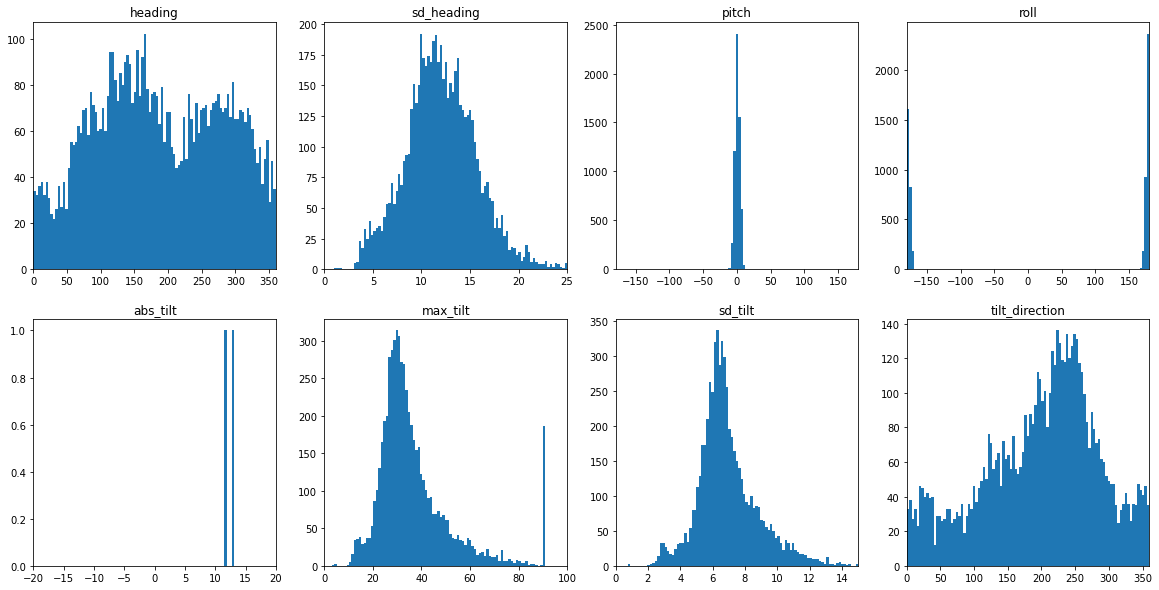

In [4]:
fig,ax=plt.subplots(2,4,figsize=(20,10))
var = ['heading','sd_heading','pitch','roll','abs_tilt','max_tilt','sd_tilt','tilt_direction']
c = 0
lims = [[0,360],[0,25],[-180,180],[-180,180],[-20,20],[0,100],[0,15],[0,360]]
for i in range(2):
    for j in range(4):   
        _=ax[i][j].hist(dcps[var[c]],bins=np.linspace(lims[c][0],lims[c][1],100))
        ax[i][j].set_title(var[c])
        ax[i][j].set_xlim(lims[c])
        c+=1

Roll and tilt seems weird, need to adjust them. Also, there seems to be occasions when the max tilt is 90°, not good.

To explain these variables, the sensor measures 150 times during one sample, then averages and outputs this. E.g., the sd_heading is the standard deviation in the heading during one sample, and the histogram here shows that there were some movement during each sample, mean around +-12 degrees. This will definitely affect the accuracy of the sensor, since we previously only corrected the entire sample for movement, and not each single ping. Tilt

In [5]:
# We need to adjust the tilt and roll parameters, since it's mounted upside down
dcps['pitch'] = -dcps['pitch']
dcps['abs_tilt'] = (((dcps['roll'] + 360) % 360) - 180) + dcps['pitch']
dcps['roll'] = (((dcps['roll'] + 360) % 360) - 180)
dcps['heading'] = (dcps['heading'] + dcps['mag_dec']) % 360
dcps['tilt_direction'] = (dcps['tilt_direction'] + dcps['mag_dec']) % 360

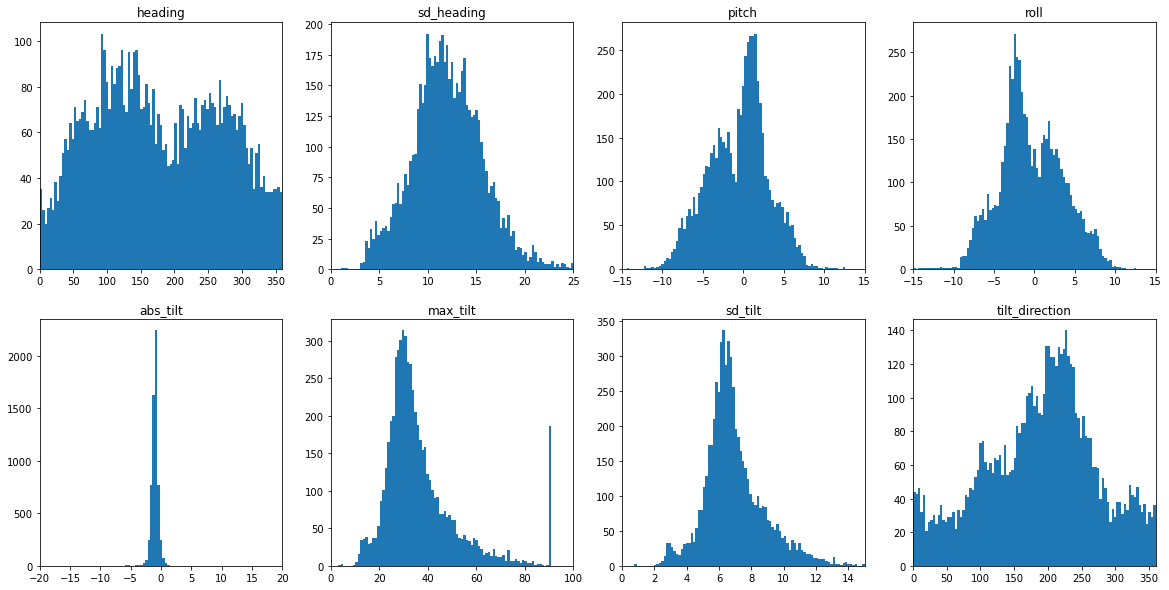

In [6]:
fig,ax=plt.subplots(2,4,figsize=(20,10))
var = ['heading','sd_heading','pitch','roll','abs_tilt','max_tilt','sd_tilt','tilt_direction']
c = 0
lims = [[0,360],[0,25],[-15,15],[-15,15],[-20,20],[0,100],[0,15],[0,360]]
for i in range(2):
    for j in range(4):   
        _=ax[i][j].hist(dcps[var[c]],bins=np.linspace(lims[c][0],lims[c][1],100))
        ax[i][j].set_title(var[c])
        ax[i][j].set_xlim(lims[c])
        c+=1

This looks better, let's cut the dataset for sd_heading < 20°, and max_tilt < 80°, and strength > -40dB as we saw before.

In [8]:
dcps = dcps.where(dcps['sd_heading'] < 20).where(dcps['max_tilt'] < 80)
dcps[['cell_index',
      'cell_state1',
      'cell_state2',
      'horizontal_speed',
      'direction',
      'north_speed',
      'east_speed',
      'vertical_speed',
      'sp_sd_horizontal',
      'strength',
      'beam1_speed',
      'beam2_speed',
      'beam3_speed',
      'beam4_speed',
      'beam1_strength',
      'beam2_strength',
      'beam3_strength',
      'beam4_strength',
      'beam1_sd',
      'beam2_sd',
      'beam3_sd',
      'beam4_sd',
      'cross_difference']] = dcps[['cell_index',
                                   'cell_state1',
                                   'cell_state2',
                                   'horizontal_speed',
                                   'direction',
                                   'north_speed',
                                   'east_speed',
                                   'vertical_speed',
                                   'sp_sd_horizontal',
                                   'strength',
                                   'beam1_speed',
                                   'beam2_speed',
                                   'beam3_speed',
                                   'beam4_speed',
                                   'beam1_strength',
                                   'beam2_strength',
                                   'beam3_strength',
                                   'beam4_strength',
                                   'beam1_sd',
                                   'beam2_sd',
                                   'beam3_sd',
                                   'beam4_sd',
                                   'cross_difference']].where(dcps['strength'] > -40) # This looks more complicated than it is, essentially it's to only correct the depth dependent variables.

In [9]:
dcps.to_netcdf('dcps_qc.nc')